In [25]:
import itertools
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import linalg
from scipy.spatial.distance import cdist
from sklearn import tree, preprocessing, mixture
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import plot_confusion_matrix, log_loss, silhouette_score, silhouette_samples, \
    calinski_harabasz_score, davies_bouldin_score, homogeneity_score, completeness_score, v_measure_score, \
    adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.random_projection import GaussianRandomProjection
from sklearn.neural_network import MLPClassifier

data = pd.read_csv("train_2.csv")
data_test = pd.read_csv("test_2.csv")


both_df = pd.concat([data, data_test], axis=0).reset_index(drop=True)
both_df.drop(["subject"], axis=1, inplace=True)
both_df = shuffle(both_df)

std_scaler = StandardScaler()
copy_both_df = both_df.copy()
X = both_df.loc[:, both_df.columns != "Activity"]
std_scaler.fit(X)
X_scaled = std_scaler.fit_transform(X)
y = both_df.Activity
labels = preprocessing.LabelEncoder().fit(y).classes_

y_encode = LabelEncoder().fit_transform(y)

copy_both_df['Activity'] = LabelEncoder().fit_transform(copy_both_df.Activity)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encode, random_state=2, test_size=.3, stratify=y)
print("Starting Cross Validation")

Starting Cross Validation


In [ ]:
skf = StratifiedKFold(n_splits = 5)
# dtc = tree.DecisionTreeClassifier(criterion="entropy", max_depth=10, min_samples_split= 10, random_state = 2)
#
# scoring = {'precision_weighted':make_scorer(precision_score, average='weighted'),
#  		   'Accuracy': make_scorer(accuracy_score)}
#kmeans = KMeans()
scoring = {'precision_weighted':make_scorer(precision_score, average='weighted'),
 		   'Accuracy': make_scorer(accuracy_score)}
#parameters = {'max_depth': [5, 10, 15, 20],'min_samples_split':[10, 15, 17, 20, 25]}
parameters = {'n_clusters': range(1,35), 'n_init':range(5,15), 'random_state': [1],
              'n_jobs':[-1], 'algorithm': ['elkan']}
clf = GridSearchCV(return_train_score=True, estimator=KMeans(),
				   param_grid=parameters, cv=skf, n_jobs=-1,
 				   scoring=scoring, refit='precision_weighted')

clf.fit(X=X_scaled, y=y_encode)
results = clf.cv_results_
print(results)

In [ ]:
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("min_samples_split")
plt.ylabel("Score")

ax = plt.gca()
ax.set_xlim(1, 36)
ax.set_ylim(0, 1)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_n_clusters'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
	for sample, style in (('train', '--'), ('test', '-')):
		sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
		sample_score_std = results['std_%s_%s' % (sample, scorer)]
		ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
		ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

	best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
	best_score = results['mean_test_%s' % scorer][best_index]

	# Plot a dotted vertical line at the best score for that scorer marked by x
	ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

	# Annotate the best score for that scorer
	ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.show()

done processing models


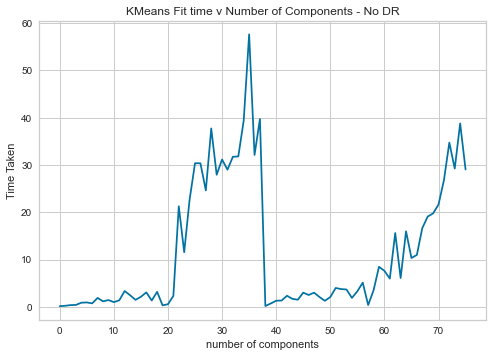

In [43]:
times = []
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'tied', 'diag', 'full']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        t1 = time.time()
        gmm.fit(X_scaled)
        t2 = time.time()
        times.append(-(t1-t2))
        bic.append(gmm.bic(X_scaled))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing models")

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("KMeans Fit time v Number of Components - No DR")
plt.show()


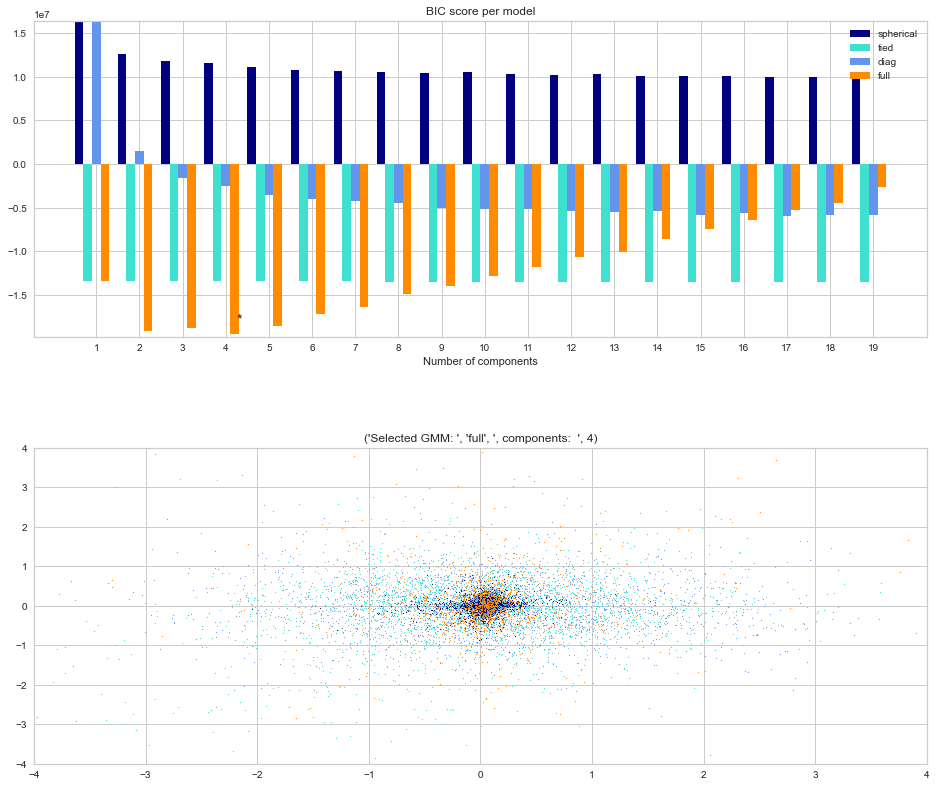

In [3]:
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_bic
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_scaled)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_scaled[Y_ == i, 0], X_scaled[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()


In [22]:
lowest_aic = np.infty
aic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'tied', 'diag', 'full']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(X_scaled)
        aic.append(gmm.aic(X_scaled))
        if aic[-1] < lowest_aic:
            lowest_aic = aic[-1]
            best_gmm = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing aic score")


C:\Users\Stephen\anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


done processing aic score


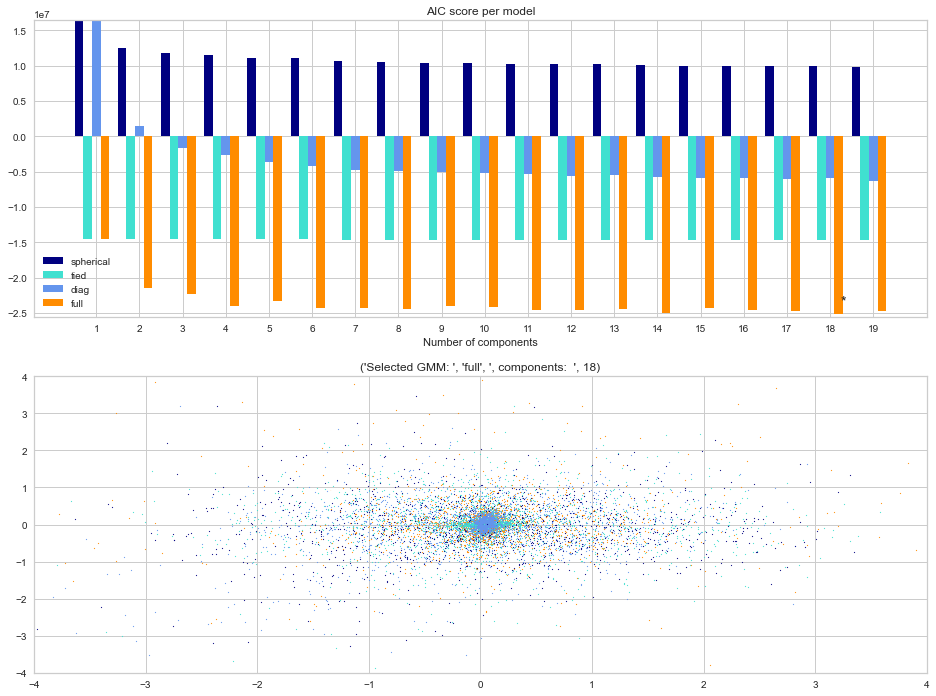

done plotting aic scores


In [39]:
aic = np.array(aic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, aic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([aic.min() * 1.01 - .01 * aic.max(), aic.max()])
plt.title('AIC score per model')
xpos = np.mod(aic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(aic.argmin() / len(n_components_range))
plt.text(xpos, aic.min() * 0.97 + .03 * aic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(X_scaled)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X_scaled[Y_ == i, 0], X_scaled[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(range(-.5, .5))
# plt.yticks(range(-1, 1))
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
# plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()
print("done plotting aic scores")

done processing models


ValueError: expected square "a" matrix

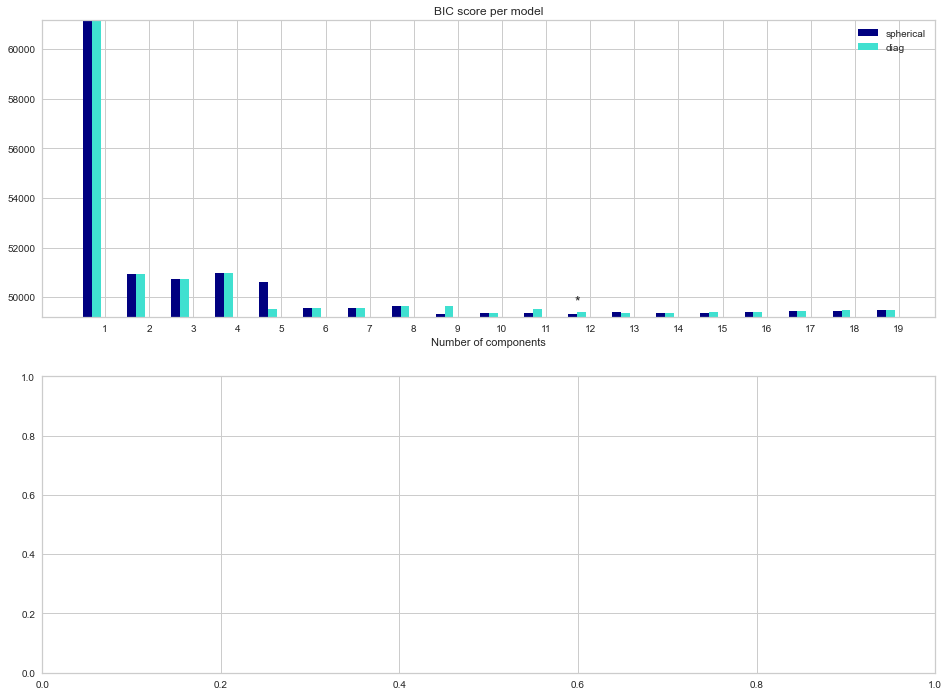

In [22]:
pca = PCA(n_components=1).fit(X_train)
pca_train = pca.transform(X_train)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(pca_train)
        bic.append(gmm.bic(pca_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing models")

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_bic
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(pca_train)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(pca_train[Y_ == i, 0], pca_train[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()



done processing models


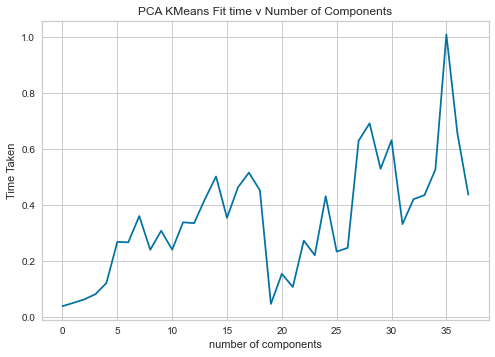

ValueError: expected square "a" matrix

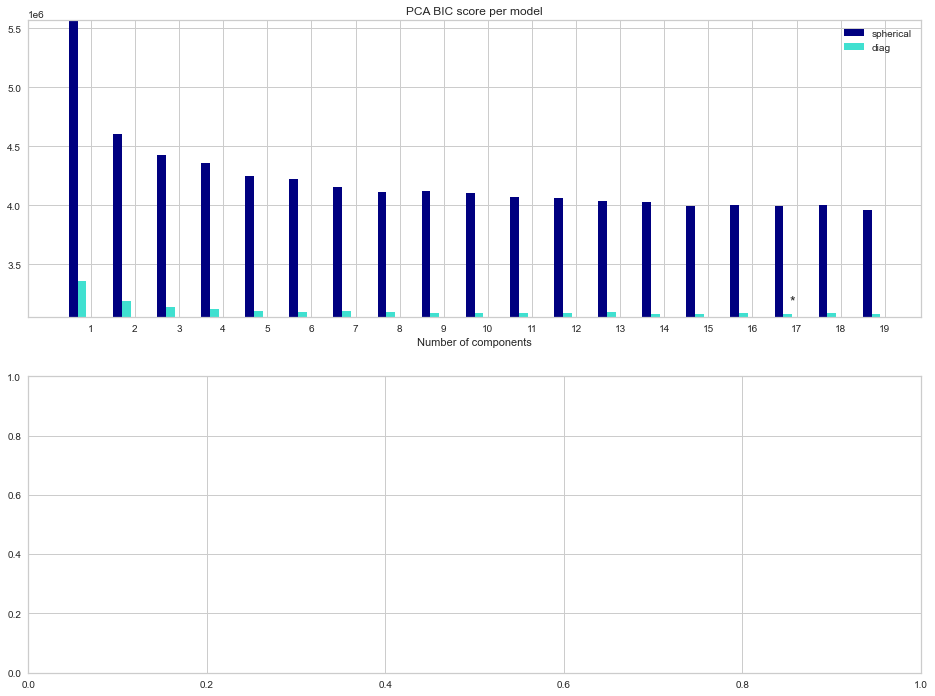

In [42]:
times = []
pca = PCA(n_components=200).fit(X_train)
pca_train = pca.transform(X_train)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        t1 = time.time()
        gmm.fit(pca_train)
        t2 = time.time()
        times.append(-(t1-t2))
        bic.append(gmm.bic(pca_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing models")

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("PCA KMeans Fit time v Number of Components")
plt.show()


bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_bic
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('PCA BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(pca_train)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(pca_train[Y_ == i, 0], pca_train[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

done processing models


ValueError: expected square "a" matrix

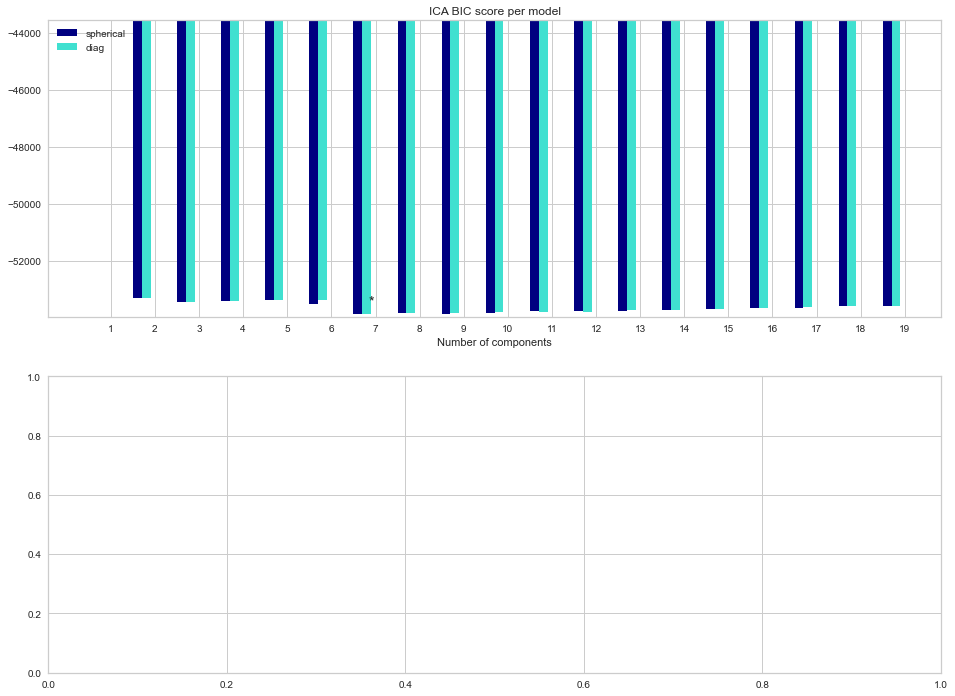

In [27]:
ica = FastICA(max_iter=300, algorithm='parallel', n_components=1).fit(X_train)
ica_train = ica.transform(X_train)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        gmm.fit(ica_train)
        bic.append(gmm.bic(ica_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing models")

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_bic
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('ICA BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(ica_train)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(ica_train[Y_ == i, 0], ica_train[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

C:\Users\Stephen\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:118: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


done processing models


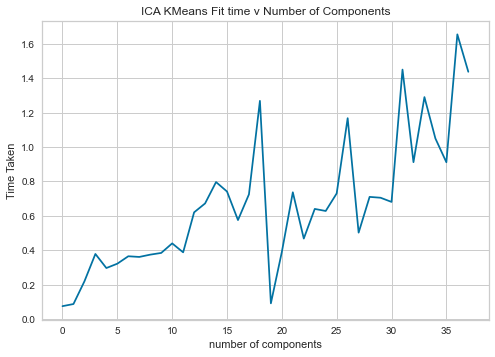

ValueError: expected square "a" matrix

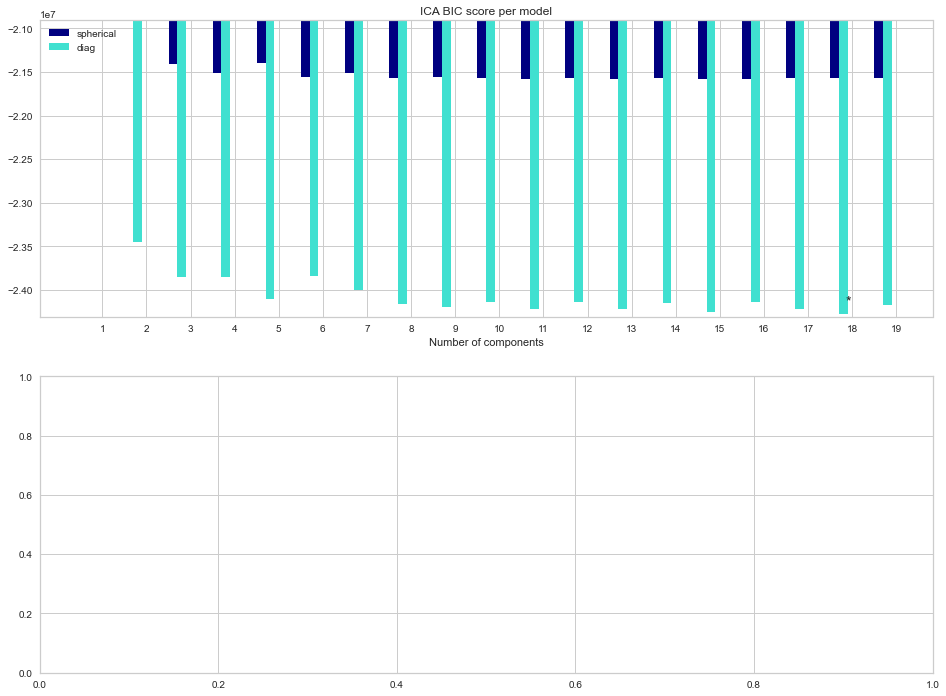

In [41]:
times = []
ica = FastICA(max_iter=500, algorithm='parallel', n_components=480).fit(X_train)
ica_train = ica.transform(X_train)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        t1 = time.time()
        gmm.fit(ica_train)
        t2 = time.time()
        times.append(-(t1-t2))
        bic.append(gmm.bic(ica_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing models")

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("ICA KMeans Fit time v Number of Components")
plt.show()


bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_bic
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('ICA BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(ica_train)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(ica_train[Y_ == i, 0], ica_train[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

C:\Users\Stephen\anaconda3\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


done processing models


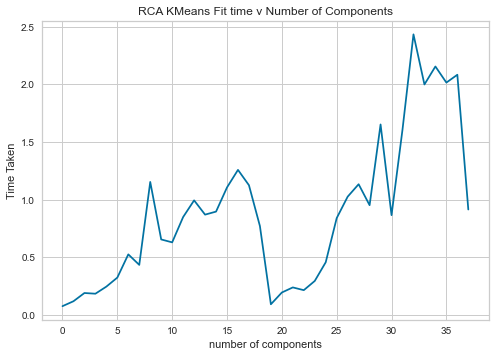

ValueError: expected square "a" matrix

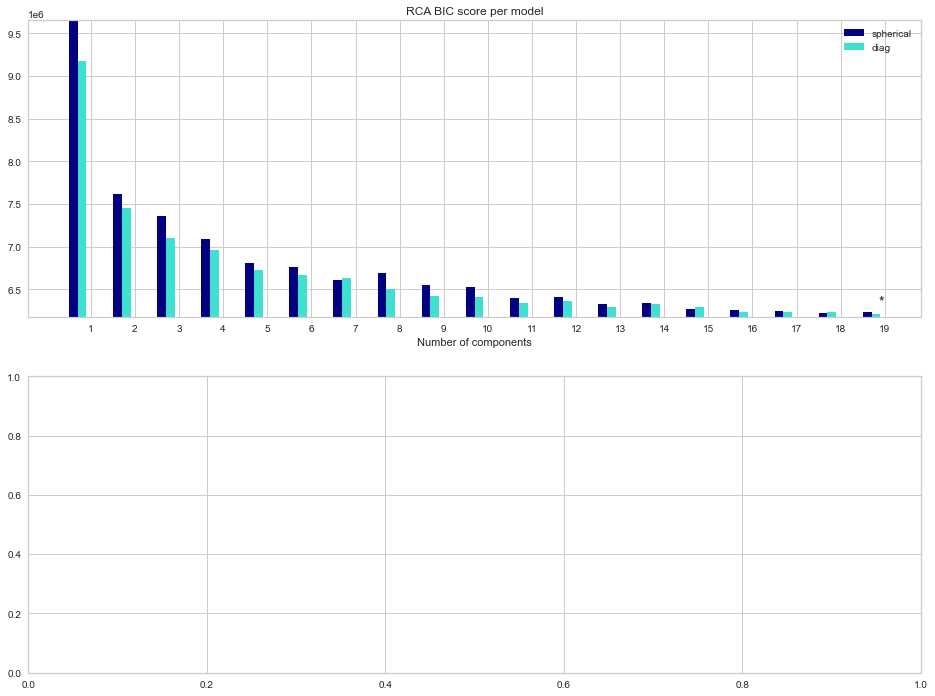

In [40]:
times = []
pca = GaussianRandomProjection(n_components=450).fit(X_train)
pca_train = pca.transform(X_train)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        t1 = time.time()
        gmm.fit(pca_train)
        t2 = time.time()
        times.append(-(t1-t2))
        bic.append(gmm.bic(pca_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing models")

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("RCA KMeans Fit time v Number of Components")
plt.show()

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_bic
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('RCA BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(pca_train)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(pca_train[Y_ == i, 0], pca_train[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

done processing models


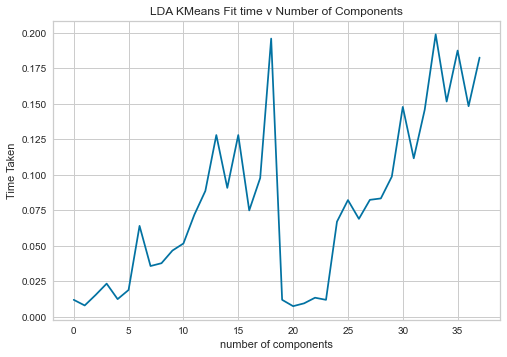

ValueError: expected square "a" matrix

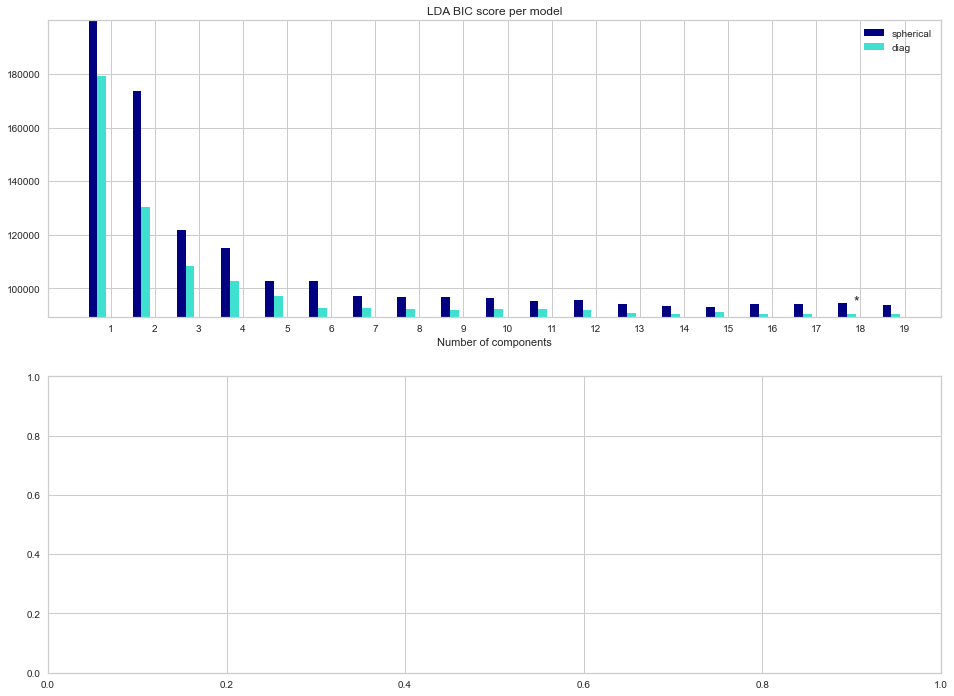

In [39]:
times = []
pca = LinearDiscriminantAnalysis(n_components=4).fit(X_train, y_train)
pca_train = pca.transform(X_train)
lowest_bic = np.infty
bic = []
n_components_range = range(1, 20)
cv_types = ['spherical', 'diag']
best_index = 0
best_cv_type = ''
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a Gaussian mixture with EM
        gmm = mixture.GaussianMixture(n_components=n_components,
                                      covariance_type=cv_type)
        t1 = time.time()
        gmm.fit(pca_train)
        t2 = time.time()
        times.append(-(t1-t2))
        bic.append(gmm.bic(pca_train))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm_bic = gmm
            best_index = n_components
            best_cv_type = cv_type
print("done processing models")

plt.plot(times)
plt.xlabel('number of components')
plt.ylabel('Time Taken')
plt.title("LDA KMeans Fit time v Number of Components")
plt.show()

bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
clf = best_gmm_bic
bars = []

# Plot the BIC scores
plt.figure(figsize=(16, 12))
spl = plt.subplot(2, 1, 1)
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('LDA BIC score per model')
xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

# Plot the winner
splot = plt.subplot(2, 1, 2)
Y_ = clf.predict(pca_train)
for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,
                                           color_iter)):
    v, w = linalg.eigh(cov)
    if not np.any(Y_ == i):
        continue
    plt.scatter(pca_train[Y_ == i, 0], pca_train[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180. * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)

# plt.xticks(())
# plt.yticks(())
splot.set_xlim([-4, 4])
splot.set_ylim([-4, 4])
title = 'Selected GMM: ', best_cv_type, ', components:  ',  best_index
plt.title(title)
plt.subplots_adjust(hspace=.35, bottom=.02)
plt.show()

In [34]:
clust = mixture.GaussianMixture(n_components=4,
                                      covariance_type='diag').fit(X_scaled)
clust_all = clust.predict_proba(X_scaled)
# clust_train = clust.transform(X_train)
# clust_test = clust.transform(X_test)
nn = MLPClassifier(activation='logistic', hidden_layer_sizes=25,
				   learning_rate_init=.3, solver='sgd', learning_rate='adaptive',
				   n_iter_no_change=50, early_stopping=True, max_iter=1000, momentum=0.3)
scoring = {'precision_weighted':make_scorer(precision_score, average='weighted')}
parameters = {'hidden_layer_sizes': [25], 'activation':['logistic', 'relu', 'tanh', 'relu', 'identity'],
			  'learning_rate':['adaptive'], 'solver':['sgd'], #'learning_rate_init':[.1, .001, .0001],
              'learning_rate_init':[.1, .2, .3, .4, .5, .6, .7, .8, .9],
              'momentum':[0.9], 'max_iter':[1000]}
skf = StratifiedKFold(n_splits = 5)
clf = GridSearchCV(return_train_score=True, estimator=MLPClassifier(),
 				   param_grid=parameters, cv=skf, n_jobs=-1, scoring=scoring, refit='precision_weighted')

clf.fit(X=clust_all, y=y_encode)
results = clf.cv_results_
print(results['mean_test_precision_weighted'])
print(clf.best_params_)
print(clf.best_score_)
# plt.figure(figsize=(13, 13))
# plt.title("GridSearchCV evaluating Neural Network",
#           fontsize=16)

# plt.xlabel("Learning Rate Size")
# plt.ylabel("Score")

# ax = plt.gca()
# ax.set_xlim(0, .1)
# ax.set_ylim(0, 1)

# # Get the regular numpy array from the MaskedArray
# X_axis = np.array(results['param_learning_rate_init'].data, dtype=float)

# for scorer, color in zip(sorted(scoring), ['g', 'k']):
# 	for sample, style in (('train', '--'), ('test', '-')):
# 		sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
# 		sample_score_std = results['std_%s_%s' % (sample, scorer)]
# 		ax.fill_between(X_axis, sample_score_mean - sample_score_std,
#                         sample_score_mean + sample_score_std,
#                         alpha=0.1 if sample == 'test' else 0, color=color)
# 		ax.plot(X_axis, sample_score_mean, style, color=color,
#                 alpha=1 if sample == 'test' else 0.7,
#                 label="%s (%s)" % (scorer, sample))

# 	best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
# 	best_score = results['mean_test_%s' % scorer][best_index]

# 	# Plot a dotted vertical line at the best score for that scorer marked by x
# 	ax.plot([X_axis[best_index], ] * 2, [0, best_score],
#             linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

# 	# Annotate the best score for that scorer
# 	ax.annotate("%0.2f" % best_score,
#                 (X_axis[best_index], best_score + 0.005))

# plt.legend(loc="best")
# plt.grid(False)
# plt.show()

KeyboardInterrupt: 

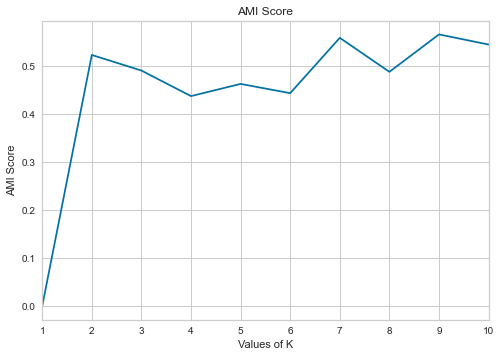

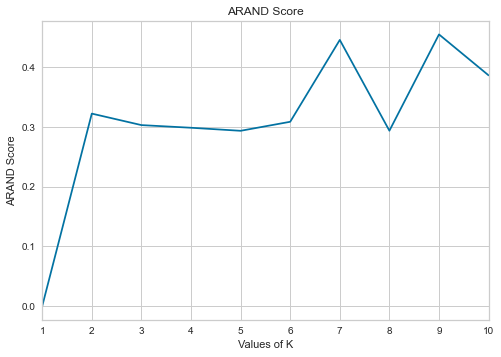

In [32]:
times = []
amis = []
arands = []
range_n_clusters = range(1, 11)
for n_clusters in range_n_clusters:

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = mixture.GaussianMixture(n_components=n_clusters,
                                      covariance_type='full',
                                      warm_start=True,
                                      max_iter=100)
    t1 = time.time()
    cluster_labels = clusterer.fit_predict(X_scaled)
    t2 = time.time()
    times.append(-(t1-t2))
    # pred = clusterer.predict(X_scaled)

    ami = adjusted_mutual_info_score(y_encode, cluster_labels)
    arand = adjusted_rand_score(y_encode, cluster_labels)
    amis.append(ami)
    arands.append(arand)

amis = np.array(amis)
arands = np.array(arands)
plt.plot(range(1,11), amis, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('AMI Score')
plt.xlim(1, 10)
plt.title('AMI Score')
plt.show()

plt.plot(range(1,11), arands, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('ARAND Score')
plt.xlim(1, 10)
plt.title('ARAND Score')
plt.show()